In [73]:
import sys, os
import pandas as pd
import numpy as np
import ast
from hmmlearn import hmm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import preprocess

# 1. Data Load

In [4]:
orig_df = pd.read_csv('./data/exhibition_behavior_preprocessed.csv', delimiter=',', index_col=False)

In [5]:
orig_df

,uid,date,filename,start,duration,A/C,behavior,code,M/F,appearance
0,0,11월 19일,01_20221119085958_part2,56240,2720,Child,물리적거리,Approach,Female,"포니테일, 아이보리색 점퍼, 검정색 바지"
1,0,11월 19일,01_20221119085958_part2,59360,2960,Child,상호작용시도,None,Female,"포니테일, 아이보리색 점퍼, 검정색 바지"
2,0,11월 19일,01_20221119085958_part2,71420,5520,Child,물리적거리,Approach,Female,"포니테일, 아이보리색 점퍼, 검정색 바지"
3,0,11월 19일,01_20221119085958_part2,77400,6320,Child,상호작용시도,None,Female,"포니테일, 아이보리색 점퍼, 검정색 바지"
4,1,11월 19일,01_20221119085958_part2,48240,9240,Child,물리적거리,Approach,Male,"검정색 점퍼, 청바지, 검정/흰색 운동화"
...,...,...,...,...,...,...,...,...,...,...
2682,371,12월 4일,01_20221204165959_part1,2567280,17280,Child,물리적거리,Pass,Female,"하늘색 롱패딩, 흰색 바지"
2683,371,12월 4일,01_20221204165959_part1,2893760,14160,Child,물리적거리,Pass,Female,"하늘색 롱패딩, 흰색 바지"
2684,372,12월 4일,01_20221204165959_part1,2567280,18080,Adult,물리적거리,Pass,Male,"검은색 롱패딩, 검은색 바지"
2685,373,12월 4일,01_20221204165959_part2,15760,13840,Child,물리적거리,Pass,Female,"하늘색 롱패딩, 흰색 바지"


Count Child/Adult, Male/Female

In [159]:
child_male_count = orig_df.loc[(orig_df['A/C'] == 'Child') & (orig_df['M/F'] == 'Male')].shape[0]
child_female_count = orig_df.loc[(orig_df['A/C'] == 'Child') & (orig_df['M/F'] == 'Female')].shape[0]
adult_male_count = orig_df.loc[(orig_df['A/C'] == 'Adult') & (orig_df['M/F'] == 'Male')].shape[0]
adult_female_count = orig_df.loc[(orig_df['A/C'] == 'Adult') & (orig_df['M/F'] == 'Female')].shape[0]

print("Child - Male:", child_male_count)
print("Child - Female:", child_female_count)
print("Adult - Male:", adult_male_count)
print("Adult - Female:", adult_female_count)

Child - Male: 1060
Child - Female: 435
Adult - Male: 375
Adult - Female: 497


Remove 'Pass' tag

In [6]:
orig_df = orig_df.drop(orig_df[orig_df['code'] == 'Pass'].index)

In [7]:
orig_df = orig_df.reset_index(drop=True)

# 2. Indexing
Avoid, Follow를 제거하지 않고 Approach와 결합하여 indexing

In [8]:
orig_df = preprocess.index_with_start(orig_df)
orig_df = preprocess.reindex(orig_df, ['uid', 'pid', 'date', 'filename', 'start', 'duration', 'A/C', 'M/F', 'behavior', 'code', 'appearance'])

In [9]:
orig_df

,uid,pid,date,filename,start,duration,A/C,M/F,behavior,code,appearance
0,0,0,11월 19일,01_20221119085958_part2,56240,2720,Child,Female,물리적거리,Approach,"포니테일, 아이보리색 점퍼, 검정색 바지"
1,0,0,11월 19일,01_20221119085958_part2,59360,2960,Child,Female,상호작용시도,None,"포니테일, 아이보리색 점퍼, 검정색 바지"
2,0,1,11월 19일,01_20221119085958_part2,71420,5520,Child,Female,물리적거리,Approach,"포니테일, 아이보리색 점퍼, 검정색 바지"
3,0,1,11월 19일,01_20221119085958_part2,77400,6320,Child,Female,상호작용시도,None,"포니테일, 아이보리색 점퍼, 검정색 바지"
4,1,2,11월 19일,01_20221119085958_part2,48240,9240,Child,Male,물리적거리,Approach,"검정색 점퍼, 청바지, 검정/흰색 운동화"
...,...,...,...,...,...,...,...,...,...,...,...
2362,367,563,12월 4일,01_20221204160000_part1,1746960,11680,Child,Male,상호작용시도,None,"검은색 롱패딩, 검은색 바지"
2363,367,563,12월 4일,01_20221204160000_part1,1758640,4800,Child,Male,물리적거리,Approach,"검은색 롱패딩, 검은색 바지"
2364,367,563,12월 4일,01_20221204160000_part1,1763440,16480,Child,Male,상호작용시도,None,"검은색 롱패딩, 검은색 바지"
2365,369,564,12월 4일,01_20221204165959_part1,2730640,12640,Child,Male,물리적거리,Approach,"갈색 후리스, 검은색 바지"


# 3. Make Data

In [10]:
def make_data(df):
    df = df.groupby('pid').agg({'code': list, 'start': list, 'duration': list, 'A/C': 'first', 'M/F': 'first', 'appearance': list})
    df['appearance'] = [set(data) for data in df['appearance']]
#     df = df.drop(df[df['code'].apply(lambda x: len(x) <= 1)].index)
    df.reset_index(inplace=True, drop=True)
    return df

In [11]:
df = orig_df[['pid', 'code', 'start', 'duration', 'A/C', 'M/F', 'appearance']]

In [12]:
df = make_data(df)

In [13]:
df

,code,start,duration,A/C,M/F,appearance
0,"[Approach, None]","[56240, 59360]","[2720, 2960]",Child,Female,"{포니테일, 아이보리색 점퍼, 검정색 바지}"
1,"[Approach, None]","[71420, 77400]","[5520, 6320]",Child,Female,"{포니테일, 아이보리색 점퍼, 검정색 바지}"
2,"[Approach, None, Approach, None]","[48240, 56640, 71200, 77400]","[9240, 15600, 5920, 6360]",Child,Male,"{검정색 점퍼, 청바지, 검정/흰색 운동화}"
3,"[Approach, None]","[238160, 242320]","[4160, 7760]",Child,Male,"{검정 마스크, 흰색 후리스, 회색 트레이닝 바지}"
4,"[Approach, None, Approach, None]","[47920, 56480, 71200, 77200]","[8640, 16480, 6000, 6640]",Adult,Female,"{검정 핸드백, 흰색 점퍼, 아이보리색 바지}"
...,...,...,...,...,...,...
560,"[None, Approach, None, Approach, None]","[1716560, 1729280, 1735360, 1768880, 1771040]","[12720, 6080, 33520, 2160, 10000]",Adult,Female,"{검은색 패딩, 회색 상의, 회색 바지}"
561,"[Approach, None]","[1573200, 1582960]","[9760, 135360]",Child,Female,"{회색 롱패딩, 흰색 바지}"
562,"[Approach, None, Approach, None, Approach, None]","[1727920, 1738320, 1744880, 1750160, 1755360, ...","[10400, 6560, 5280, 5200, 4560, 20800]",Child,Female,"{회색 롱패딩, 흰색 바지}"
563,"[Approach, None, Gesture, None, Approach, None...","[1566960, 1574640, 1579840, 1582640, 1585040, ...","[7680, 5200, 2800, 2400, 5360, 45360, 1840, 36...",Child,Male,"{검은색 롱패딩, 검은색 바지}"


In [14]:
df.reset_index(inplace=True, drop=True)
df.index

RangeIndex(start=0, stop=565, step=1)

## 3-1) 이상치 제거

In [15]:
print("1. code list가 상호작용시도 code로 시작하고 list 내에 approach가 없는 code list 제거")
count = 0

for i in df.index:
    try:
        if (df['code'][i][0] == 'None' or df['code'][i][0] == 'Touch' or df['code'][i][0] == 'Gesture'):
            if 'Approach' not in df['code'][i]:
                print(df['code'][i])
                df.drop(i, inplace=True)
                count += 1
    except: 
        break
        
print("drop한 데이터 개수:", count)

1. code list가 상호작용시도 code로 시작하고 list 내에 approach가 없는 code list 제거
['None']
['None', 'Touch', 'None', 'Touch']
['Gesture']
['None', 'Avoid']
['Touch', 'Avoid']
['None']
['Gesture']
['Touch', 'None']
['None']
['Gesture', 'None', 'Touch', 'None']
['Touch']
['Touch']
['Touch', 'None']
['Touch']
['Touch']
['Touch']
['Touch']
['Touch']
['Touch', 'Touch']
['None']
['None']
['None']
['None']
['None', 'Touch', 'None', 'Touch', 'None']
['None']
['Gesture', 'None', 'Gesture']
['Gesture']
['None']
['None']
['None']
['Gesture']
['None']
['None']
['None']
['None']
['None']
['None']
['None']
['None', 'Avoid']
['None']
['None']
['None', 'Touch', 'None', 'Touch', 'None']
['None']
['None']
drop한 데이터 개수: 44


In [16]:
print("2. code list가 상호작용시도 코드로 시작하지만 Approach 코드가 있는 경우 Approach 이전의 상호작용시도 code들을 제거")
index = 0
count = 0

for i in df.index:
    try:
        index = 0
        if (df['code'][i][0] == 'None' or df['code'][i][0] == 'Touch' or df['code'][i][0] == 'Gesture') \
                and ('Approach' in df['code'][i]):
            for code in df['code'][i]:
                if code != 'Approach' and code != 'Avoid' and code != 'Follow':
                    index += 1
                else:
                    break
            if index != 0:
                print("before:", df['code'][i])
#                 print("before:", df['start'][i])
#                 print("before:", df['duration'][i])
                
                print("after: ", df['code'][i][index:])
#                 print("after: ", df['start'][i][index:])
#                 print("after: ", df['duration'][i][index:])
                print("---------------------------------------")
                
                df['code'][i] = df['code'][i][index:]
                df['start'][i] = df['start'][i][index:]
                df['duration'][i] = df['duration'][i][index:]
                
                count += 1
    except: 
        break

print("값을 바꾼 데이터 개수:", count)

2. code list가 상호작용시도 코드로 시작하지만 Approach 코드가 있는 경우 Approach 이전의 상호작용시도 code들을 제거
before: ['Touch', 'Approach']
after:  ['Approach']
---------------------------------------
before: ['Gesture', 'Avoid', 'Approach', 'Touch', 'None', 'Touch', 'Avoid', 'Follow', 'Approach', 'Approach', 'Touch', 'None', 'Touch', 'None', 'Touch', 'None']
after:  ['Avoid', 'Approach', 'Touch', 'None', 'Touch', 'Avoid', 'Follow', 'Approach', 'Approach', 'Touch', 'None', 'Touch', 'None', 'Touch', 'None']
---------------------------------------
before: ['None', 'Touch', 'None', 'Touch', 'None', 'Approach', 'None', 'Touch', 'None', 'Touch']
after:  ['Approach', 'None', 'Touch', 'None', 'Touch']
---------------------------------------
before: ['Touch', 'None', 'Approach', 'None', 'Touch', 'None', 'Approach', 'None']
after:  ['Approach', 'None', 'Touch', 'None', 'Approach', 'None']
---------------------------------------
before: ['None', 'Approach', 'Touch', 'None', 'Gesture', 'Touch', 'None', 'Gesture', 'Touch', 'No

In [17]:
print("3. code list에 Avoid 또는 Follow와 상호작용시도 code로만 이루어진 code list 제거")
count = 0

for i in df.index:
    try:
        if (len(df['code'][i]) > 1) and (df['code'][i][0] == 'Avoid' or df['code'][i][0] == 'Follow'):
            if 'Approach' not in df['code'][i]:
                print(df['code'][i])
                df.drop(i, inplace=True)
                count += 1
    except:
        break

print("drop한 데이터 개수:", count)

3. code list에 Avoid 또는 Follow와 상호작용시도 code로만 이루어진 code list 제거
['Avoid', 'None']
['Follow', 'None']
['Avoid', 'None']
['Avoid', 'None', 'Touch']
['Follow', 'Avoid', 'Follow']
['Avoid', 'None']
['Follow', 'Avoid']
['Avoid', 'Follow']
['Avoid', 'Follow']
['Avoid', 'Follow']
['Follow', 'Avoid']
drop한 데이터 개수: 11


In [18]:
print("4. code list의 길이가 1 이하인 code list를 제거")
count = 0

for i in df.index:
    try:
        if len(df['code'][i]) <= 1: 
#             or 'Approach' not in df['code'][i]) \
#                 or (len(df['code'][i]) <= 1 and 'Approach' in df['code'][i]):
            print(df['code'][i])
            df.drop(i, inplace=True)
            count += 1
    except:
        break

print("drop한 데이터 개수:", count)
df.reset_index(inplace=True, drop=True)

4. code list의 길이가 1 이하인 code list를 제거
['Approach']
['Follow']
['Follow']
['Follow']
['Follow']
['Approach']
['Follow']
['Approach']
['Follow']
['Approach']
['Approach']
['Approach']
['Approach']
['Approach']
['Approach']
['Approach']
['Approach']
['Approach']
['Avoid']
['Follow']
['Approach']
['Follow']
['Approach']
['Approach']
['Approach']
drop한 데이터 개수: 25


In [19]:
df.reset_index(inplace=True, drop=True)
df.index

RangeIndex(start=0, stop=485, step=1)

In [20]:
df

,code,start,duration,A/C,M/F,appearance
0,"[Approach, None]","[56240, 59360]","[2720, 2960]",Child,Female,"{포니테일, 아이보리색 점퍼, 검정색 바지}"
1,"[Approach, None]","[71420, 77400]","[5520, 6320]",Child,Female,"{포니테일, 아이보리색 점퍼, 검정색 바지}"
2,"[Approach, None, Approach, None]","[48240, 56640, 71200, 77400]","[9240, 15600, 5920, 6360]",Child,Male,"{검정색 점퍼, 청바지, 검정/흰색 운동화}"
3,"[Approach, None]","[238160, 242320]","[4160, 7760]",Child,Male,"{검정 마스크, 흰색 후리스, 회색 트레이닝 바지}"
4,"[Approach, None, Approach, None]","[47920, 56480, 71200, 77200]","[8640, 16480, 6000, 6640]",Adult,Female,"{검정 핸드백, 흰색 점퍼, 아이보리색 바지}"
...,...,...,...,...,...,...
480,"[Approach, None, Approach, None]","[1729280, 1735360, 1768880, 1771040]","[6080, 33520, 2160, 10000]",Adult,Female,"{검은색 패딩, 회색 상의, 회색 바지}"
481,"[Approach, None]","[1573200, 1582960]","[9760, 135360]",Child,Female,"{회색 롱패딩, 흰색 바지}"
482,"[Approach, None, Approach, None, Approach, None]","[1727920, 1738320, 1744880, 1750160, 1755360, ...","[10400, 6560, 5280, 5200, 4560, 20800]",Child,Female,"{회색 롱패딩, 흰색 바지}"
483,"[Approach, None, Gesture, None, Approach, None...","[1566960, 1574640, 1579840, 1582640, 1585040, ...","[7680, 5200, 2800, 2400, 5360, 45360, 1840, 36...",Child,Male,"{검은색 롱패딩, 검은색 바지}"


In [21]:
df.to_csv('./data/behavior_hmm_data.csv')

## 3-2) One-Hot Encoding (code, duration)

In [22]:
def code_one_hot_encoding(df):
    # 행동 코드 리스트
    actions = ['Avoid', 'Follow', 'Approach', 'None', 'Touch', 'Gesture']

    # 각각의 sublist를 one-hot encoding하여 다차원 리스트로 생성
    one_hot_data = []
    for sublist in df['code']:
        one_hot_sublist = np.zeros((len(sublist), len(actions)))
        for i, code in enumerate(sublist):
            index = actions.index(code)
            one_hot_sublist[i][index] = 1
        one_hot_data.append(one_hot_sublist)
    
    df['encoded_code'] = one_hot_data
    df['encoded_code'] = df[['encoded_code']].apply(lambda x: [np.array(item).astype(int) for item in x])

    return df

In [23]:
def duration_one_hot_encoding(df):
    # 행동 코드 리스트
    actions = ['Avoid', 'Follow', 'Approach', 'None', 'Touch', 'Gesture']

    # 각각의 sublist를 one-hot encoding하여 다차원 리스트로 생성
    one_hot_data = []
    for i, sublist in enumerate(df['code']):
        one_hot_sublist = np.zeros((len(sublist), len(actions)))
        for j, code in enumerate(sublist):
            index = actions.index(code)
            one_hot_sublist[j][index] = df['duration'][i][j]
        one_hot_data.append(one_hot_sublist)
    
    df['encoded_duration'] = one_hot_data
    df['encoded_duration'] = df[['encoded_duration']].apply(lambda x: [np.array(item).astype(int) for item in x])

    return df

In [24]:
df = code_one_hot_encoding(df)
df = duration_one_hot_encoding(df)

In [25]:
df

,code,start,duration,A/C,M/F,appearance,encoded_code,encoded_duration
0,"[Approach, None]","[56240, 59360]","[2720, 2960]",Child,Female,"{포니테일, 아이보리색 점퍼, 검정색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0]]","[[0, 0, 2720, 0, 0, 0], [0, 0, 0, 2960, 0, 0]]"
1,"[Approach, None]","[71420, 77400]","[5520, 6320]",Child,Female,"{포니테일, 아이보리색 점퍼, 검정색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0]]","[[0, 0, 5520, 0, 0, 0], [0, 0, 0, 6320, 0, 0]]"
2,"[Approach, None, Approach, None]","[48240, 56640, 71200, 77400]","[9240, 15600, 5920, 6360]",Child,Male,"{검정색 점퍼, 청바지, 검정/흰색 운동화}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 9240, 0, 0, 0], [0, 0, 0, 15600, 0, 0]..."
3,"[Approach, None]","[238160, 242320]","[4160, 7760]",Child,Male,"{검정 마스크, 흰색 후리스, 회색 트레이닝 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0]]","[[0, 0, 4160, 0, 0, 0], [0, 0, 0, 7760, 0, 0]]"
4,"[Approach, None, Approach, None]","[47920, 56480, 71200, 77200]","[8640, 16480, 6000, 6640]",Adult,Female,"{검정 핸드백, 흰색 점퍼, 아이보리색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 8640, 0, 0, 0], [0, 0, 0, 16480, 0, 0]..."
...,...,...,...,...,...,...,...,...
480,"[Approach, None, Approach, None]","[1729280, 1735360, 1768880, 1771040]","[6080, 33520, 2160, 10000]",Adult,Female,"{검은색 패딩, 회색 상의, 회색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 6080, 0, 0, 0], [0, 0, 0, 33520, 0, 0]..."
481,"[Approach, None]","[1573200, 1582960]","[9760, 135360]",Child,Female,"{회색 롱패딩, 흰색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0]]","[[0, 0, 9760, 0, 0, 0], [0, 0, 0, 135360, 0, 0]]"
482,"[Approach, None, Approach, None, Approach, None]","[1727920, 1738320, 1744880, 1750160, 1755360, ...","[10400, 6560, 5280, 5200, 4560, 20800]",Child,Female,"{회색 롱패딩, 흰색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 10400, 0, 0, 0], [0, 0, 0, 6560, 0, 0]..."
483,"[Approach, None, Gesture, None, Approach, None...","[1566960, 1574640, 1579840, 1582640, 1585040, ...","[7680, 5200, 2800, 2400, 5360, 45360, 1840, 36...",Child,Male,"{검은색 롱패딩, 검은색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 7680, 0, 0, 0], [0, 0, 0, 5200, 0, 0],..."


## 3-3) Add Zero Padding
sequence가 가장 긴 data에 맞춰 zero padding을 더함

In [26]:
def padding_encoding_data(df, col_name, num):
    max_length = max(map(len, df[col_name]))  # 가장 긴 sequence의 길이 구하기
    padded_data = []
    
    for data in df[col_name]:
        if max_length - len(data) == 0:
            padded_data.append(data)
        else:
            # 가장 긴 sequence 길이를 기준으로 padding 적용
            padding_list = [[0 for i in range(num)]] * (max_length - len(data))
            result = np.concatenate((data, padding_list), axis=0)
            padded_data.append(result)
        
    df[col_name] = padded_data

    return df

In [27]:
df = padding_encoding_data(df, "encoded_code", 6)
df = padding_encoding_data(df, "encoded_duration", 6)

In [28]:
df

,code,start,duration,A/C,M/F,appearance,encoded_code,encoded_duration
0,"[Approach, None]","[56240, 59360]","[2720, 2960]",Child,Female,"{포니테일, 아이보리색 점퍼, 검정색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 2720, 0, 0, 0], [0, 0, 0, 2960, 0, 0],..."
1,"[Approach, None]","[71420, 77400]","[5520, 6320]",Child,Female,"{포니테일, 아이보리색 점퍼, 검정색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 5520, 0, 0, 0], [0, 0, 0, 6320, 0, 0],..."
2,"[Approach, None, Approach, None]","[48240, 56640, 71200, 77400]","[9240, 15600, 5920, 6360]",Child,Male,"{검정색 점퍼, 청바지, 검정/흰색 운동화}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 9240, 0, 0, 0], [0, 0, 0, 15600, 0, 0]..."
3,"[Approach, None]","[238160, 242320]","[4160, 7760]",Child,Male,"{검정 마스크, 흰색 후리스, 회색 트레이닝 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 4160, 0, 0, 0], [0, 0, 0, 7760, 0, 0],..."
4,"[Approach, None, Approach, None]","[47920, 56480, 71200, 77200]","[8640, 16480, 6000, 6640]",Adult,Female,"{검정 핸드백, 흰색 점퍼, 아이보리색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 8640, 0, 0, 0], [0, 0, 0, 16480, 0, 0]..."
...,...,...,...,...,...,...,...,...
480,"[Approach, None, Approach, None]","[1729280, 1735360, 1768880, 1771040]","[6080, 33520, 2160, 10000]",Adult,Female,"{검은색 패딩, 회색 상의, 회색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 6080, 0, 0, 0], [0, 0, 0, 33520, 0, 0]..."
481,"[Approach, None]","[1573200, 1582960]","[9760, 135360]",Child,Female,"{회색 롱패딩, 흰색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 9760, 0, 0, 0], [0, 0, 0, 135360, 0, 0..."
482,"[Approach, None, Approach, None, Approach, None]","[1727920, 1738320, 1744880, 1750160, 1755360, ...","[10400, 6560, 5280, 5200, 4560, 20800]",Child,Female,"{회색 롱패딩, 흰색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 10400, 0, 0, 0], [0, 0, 0, 6560, 0, 0]..."
483,"[Approach, None, Gesture, None, Approach, None...","[1566960, 1574640, 1579840, 1582640, 1585040, ...","[7680, 5200, 2800, 2400, 5360, 45360, 1840, 36...",Child,Male,"{검은색 롱패딩, 검은색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 7680, 0, 0, 0], [0, 0, 0, 5200, 0, 0],..."


## 3-4) Make Time Series Data
code list와 duration list를 병합하여 시계열 데이터로 변환

In [29]:
def make_data_for_hmm(df):
    time_series_data = []

    for encoded_code, encoded_duration in zip(df['encoded_code'], df['encoded_duration']):
        encoded_code = np.squeeze(encoded_code)
        encoded_duration = np.squeeze(encoded_duration)

        # encoded_code와 encoded_duration을 수평으로 결합합니다.
        time_series_data.append(np.hstack([encoded_code, encoded_duration]))

    df['time_series_data'] = time_series_data
    
    return df

In [30]:
df = make_data_for_hmm(df)

In [31]:
df

,code,start,duration,A/C,M/F,appearance,encoded_code,encoded_duration,time_series_data
0,"[Approach, None]","[56240, 59360]","[2720, 2960]",Child,Female,"{포니테일, 아이보리색 점퍼, 검정색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 2720, 0, 0, 0], [0, 0, 0, 2960, 0, 0],...","[[0, 0, 1, 0, 0, 0, 0, 0, 2720, 0, 0, 0], [0, ..."
1,"[Approach, None]","[71420, 77400]","[5520, 6320]",Child,Female,"{포니테일, 아이보리색 점퍼, 검정색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 5520, 0, 0, 0], [0, 0, 0, 6320, 0, 0],...","[[0, 0, 1, 0, 0, 0, 0, 0, 5520, 0, 0, 0], [0, ..."
2,"[Approach, None, Approach, None]","[48240, 56640, 71200, 77400]","[9240, 15600, 5920, 6360]",Child,Male,"{검정색 점퍼, 청바지, 검정/흰색 운동화}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 9240, 0, 0, 0], [0, 0, 0, 15600, 0, 0]...","[[0, 0, 1, 0, 0, 0, 0, 0, 9240, 0, 0, 0], [0, ..."
3,"[Approach, None]","[238160, 242320]","[4160, 7760]",Child,Male,"{검정 마스크, 흰색 후리스, 회색 트레이닝 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 4160, 0, 0, 0], [0, 0, 0, 7760, 0, 0],...","[[0, 0, 1, 0, 0, 0, 0, 0, 4160, 0, 0, 0], [0, ..."
4,"[Approach, None, Approach, None]","[47920, 56480, 71200, 77200]","[8640, 16480, 6000, 6640]",Adult,Female,"{검정 핸드백, 흰색 점퍼, 아이보리색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 8640, 0, 0, 0], [0, 0, 0, 16480, 0, 0]...","[[0, 0, 1, 0, 0, 0, 0, 0, 8640, 0, 0, 0], [0, ..."
...,...,...,...,...,...,...,...,...,...
480,"[Approach, None, Approach, None]","[1729280, 1735360, 1768880, 1771040]","[6080, 33520, 2160, 10000]",Adult,Female,"{검은색 패딩, 회색 상의, 회색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 6080, 0, 0, 0], [0, 0, 0, 33520, 0, 0]...","[[0, 0, 1, 0, 0, 0, 0, 0, 6080, 0, 0, 0], [0, ..."
481,"[Approach, None]","[1573200, 1582960]","[9760, 135360]",Child,Female,"{회색 롱패딩, 흰색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 9760, 0, 0, 0], [0, 0, 0, 135360, 0, 0...","[[0, 0, 1, 0, 0, 0, 0, 0, 9760, 0, 0, 0], [0, ..."
482,"[Approach, None, Approach, None, Approach, None]","[1727920, 1738320, 1744880, 1750160, 1755360, ...","[10400, 6560, 5280, 5200, 4560, 20800]",Child,Female,"{회색 롱패딩, 흰색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 10400, 0, 0, 0], [0, 0, 0, 6560, 0, 0]...","[[0, 0, 1, 0, 0, 0, 0, 0, 10400, 0, 0, 0], [0,..."
483,"[Approach, None, Gesture, None, Approach, None...","[1566960, 1574640, 1579840, 1582640, 1585040, ...","[7680, 5200, 2800, 2400, 5360, 45360, 1840, 36...",Child,Male,"{검은색 롱패딩, 검은색 바지}","[[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0...","[[0, 0, 7680, 0, 0, 0], [0, 0, 0, 5200, 0, 0],...","[[0, 0, 1, 0, 0, 0, 0, 0, 7680, 0, 0, 0], [0, ..."


In [32]:
df.to_csv("./data/behavior_hmm_preprocessed.csv")

# HMM

In [33]:
time_series_data = []

for encoded_code, encoded_duration in zip(df['encoded_code'], df['encoded_duration']):
    encoded_code = np.squeeze(encoded_code)
    encoded_duration = np.squeeze(encoded_duration)

    # encoded_code와 encoded_duration을 수평으로 결합합니다.
    time_series_data.append(np.hstack([encoded_code, encoded_duration]))

time_series_data = np.array(time_series_data)
n_samples, n_timesteps, n_features = time_series_data.shape

In [34]:
X = time_series_data.reshape((n_samples, n_timesteps * n_features))

In [35]:
def store_results(df, predicted_results, filename):
    # Decode the predicted states back to engagement levels
    results = np.array(['state0' if s == 2 else 'state1' if s == 1 else 'state2' for s in predicted_results])

    # Calculate the score (you can use any evaluation metric you want)
    # score = model.score(X)
    
    behavior = df[['code', 'duration', 'A/C', 'M/F']]
    behavior['predicted_engagement_levels'] = results
    
    # 저장할 파일 경로
    file_path = './data/' + filename
    # ExcelWriter 객체 생성
    writer = pd.ExcelWriter(file_path)

    state0_df = behavior[behavior['predicted_engagement_levels'] == 'state0']
    state1_df = behavior[behavior['predicted_engagement_levels'] == 'state1']
    state2_df = behavior[behavior['predicted_engagement_levels'] == 'state2']
    
    # 각 DataFrame을 다른 시트에 저장
    state0_df.to_excel(writer, sheet_name='state0', index=False)
    state1_df.to_excel(writer, sheet_name='state1', index=False)
    state2_df.to_excel(writer, sheet_name='state2', index=False)

    # 저장 및 파일 닫기
    writer.save()
    writer.close()

In [36]:
def print_trained_params(model):
    # Print trained parameters and plot
    print(">> Transition matrix")
    print(np.round(model.transmat_, 2))
    print()

    print(">> Initial Probability")
    print(np.round(model.startprob_, 2))

## Grid Search with K-Fold Cross Validation

In [127]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from hmmlearn import hmm

# Grid search parameters
n_states = [3, 4, 5]  # Possible number of states
covariance_type = ['diag', 'full']  # Possible covariance types
min_covar = [0.001, 0.01, 0.1]  # Minimum covariance value
n_iter = [10, 50, 100]  # Number of iterations
algorithm = ['viterbi', 'map']  # Decoding algorithm

parameters = {'n_components': n_states, 'covariance_type': covariance_type, 'min_covar': min_covar, 'n_iter': n_iter, 'algorithm': algorithm}

# HMM 모델 생성
model = hmm.GaussianHMM(random_state=79)

# GridSearchCV를 사용하여 최적의 매개변수 탐색
cv = KFold(n_splits=5)  # 5-fold cross validation
grid_search = GridSearchCV(model, parameters, cv=cv)
grid_search.fit(X)

Model is not converging.  Current: 193809.70005036992 is not greater than 193809.7000844024. Delta is -3.4032476833090186e-05
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: 193809.70005036992 is not greater than 193809.7000844024. Delta is -3.4032476833090186e-05
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Mode

Model is not converging.  Current: 753937.3431328923 is not greater than 753942.1016250246. Delta is -4.75849213229958
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Model is not converging.  Current: 747393.6891225169 is not greater than 747400.4621453373. Delta is -6.773022820358165
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Model is not converging.  Current: 753937.3431328923 is not greater than 753942.1016250246. Delta is -4.75849213229958
Fitting a model with 261375 free scalar parameters w

Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Model is not converging.  Current: 712560.8331110673 is not greater than 712560.8427685669. Delta is -0.009657499613240361
Fitting a model with 326724 free scalar parameters 

Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Model is not converging.  Current: 712899.3916156508 is not greater than 712899.5490577051. Delta is -0.15744205424562097
Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Model is not converging.  Current: 193809.70005036992 is not greater than 193809.7000844024. Delta is -3.4032476833090186e-05
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
S

Model is not converging.  Current: 444352.9604064726 is not greater than 444356.5416652227. Delta is -3.581258750113193
Fitting a model with 196028 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 196028 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Model is not converging.  Current: 753937.3431328923 is not greater than 753942.1016250246. Delta is -4.75849213229958
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Model is not converging.  Current: 747393.6891225169 

Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Model is not converging.  Current: 758602.8352846284 is not greater than 758605.6580138152. Delta is -2.8227291867369786
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 261375 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 326724 free scalar parameters wi

Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Model is not converging.  Current: 712899.3916156508 is not greater than 712899.5490577051. Delta is -0.15744205424562097
Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Fitting a model with 326724 free scalar parameters with only 139680 data points will result in a degenerate solution.
Model is not converging.  Current: 712899.3916156508

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GaussianHMM(random_state=79),
             param_grid={'algorithm': ['viterbi', 'map'],
                         'covariance_type': ['diag', 'full'],
                         'min_covar': [0.001, 0.01, 0.1],
                         'n_components': [3, 4, 5], 'n_iter': [10, 50, 100]})

In [128]:
# 최적의 매개변수 확인
best_params = grid_search.best_params_
best_params

{'algorithm': 'viterbi',
 'covariance_type': 'diag',
 'min_covar': 0.001,
 'n_components': 5,
 'n_iter': 10}

In [129]:
# 하이퍼 파라미터 조합별 로그 우도(log likelihood) 출력
for i in range(len(grid_search.cv_results_['params'])):
    params = grid_search.cv_results_['params'][i]
    mean_test_score = grid_search.cv_results_['mean_test_score'][i]
    print(f"로그 우도(log likelihood) for parameters {params}: {mean_test_score}")

로그 우도(log likelihood) for parameters {'algorithm': 'viterbi', 'covariance_type': 'diag', 'min_covar': 0.001, 'n_components': 3, 'n_iter': 10}: nan
로그 우도(log likelihood) for parameters {'algorithm': 'viterbi', 'covariance_type': 'diag', 'min_covar': 0.001, 'n_components': 3, 'n_iter': 50}: nan
로그 우도(log likelihood) for parameters {'algorithm': 'viterbi', 'covariance_type': 'diag', 'min_covar': 0.001, 'n_components': 3, 'n_iter': 100}: nan
로그 우도(log likelihood) for parameters {'algorithm': 'viterbi', 'covariance_type': 'diag', 'min_covar': 0.001, 'n_components': 4, 'n_iter': 10}: -2681257700032.994
로그 우도(log likelihood) for parameters {'algorithm': 'viterbi', 'covariance_type': 'diag', 'min_covar': 0.001, 'n_components': 4, 'n_iter': 50}: -2681257700032.994
로그 우도(log likelihood) for parameters {'algorithm': 'viterbi', 'covariance_type': 'diag', 'min_covar': 0.001, 'n_components': 4, 'n_iter': 100}: -2681257700032.994
로그 우도(log likelihood) for parameters {'algorithm': 'viterbi', 'covarian

In [136]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from hmmlearn import hmm

# Grid search parameters
n_states = [2, 3, 4, 5]  # Possible number of states

parameters = {'n_components': n_states}

# HMM 모델 생성
model = hmm.GaussianHMM(random_state=300)

# GridSearchCV를 사용하여 최적의 매개변수 탐색
cv = KFold(n_splits=5)  # 5-fold cross validation
grid_search = GridSearchCV(model, parameters, cv=cv)
grid_search.fit(X)

Model is not converging.  Current: 273579.2996724811 is not greater than 273579.3041749066. Delta is -0.004502425494138151
Model is not converging.  Current: 326021.6115552326 is not greater than 326021.6115552519. Delta is -1.9266735762357712e-08


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GaussianHMM(random_state=300),
             param_grid={'n_components': [2, 3, 4, 5]})

In [143]:
# 최적의 매개변수 확인
best_params = grid_search.best_params_
best_params

{'n_components': 3}

In [139]:
log_likelihoods = []

# 하이퍼 파라미터 조합별 로그 우도(log likelihood) 출력
for i in range(len(grid_search.cv_results_['params'])):
    params = grid_search.cv_results_['params'][i]
    mean_test_score = grid_search.cv_results_['mean_test_score'][i]
    log_likelihoods.append(mean_test_score)
    print(f"로그 우도(log likelihood) for parameters {params}: {mean_test_score}")

로그 우도(log likelihood) for parameters {'n_components': 2}: -3898278969367.7627
로그 우도(log likelihood) for parameters {'n_components': 3}: -2631346859620.8584
로그 우도(log likelihood) for parameters {'n_components': 4}: -3484976123402.0615
로그 우도(log likelihood) for parameters {'n_components': 5}: -3849667465869.383


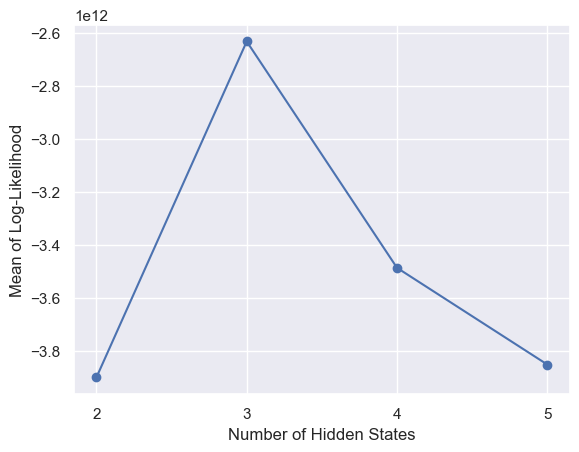

In [148]:
# 시각화
sns.set()
plt.plot(n_components, log_likelihoods, marker='o')
plt.xlabel('Number of Hidden States')
plt.ylabel('Mean of Log-Likelihood')
plt.xticks(n_components, n_components)

plt.savefig('./fig/loglikelihood.png') # 그래프 저장

plt.show()

In [146]:
# 최적의 매개변수로 모델 재학습 및 저장
best_model = hmm.GaussianHMM(**best_params)
best_model.fit(X)

predicted_states = best_model.predict(X)
    
store_results(df, predicted_states, \
                  'final_behavior_hmm_result_n_states'+str(3)+'.xlsx')

In [149]:
print_trained_params(best_model)

>> Transition matrix
[[0.1  0.74 0.17]
 [0.1  0.71 0.19]
 [0.05 0.63 0.32]]

>> Initial Probability
[0. 1. 0.]


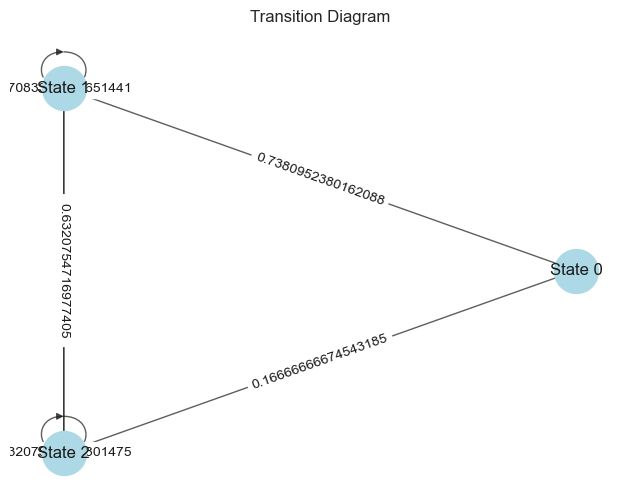

In [151]:
import networkx as nx
import matplotlib.pyplot as plt

num_states = 3
threshold = 0.1

# 유향 그래프 생성
G = nx.DiGraph()

# 그래프에 노드 추가
num_states = best_model.n_components
states = range(num_states)
G.add_nodes_from(states)

# 상태 간의 전이 확률을 기반으로 화살표 추가
for i in states:
    for j in states:
        if best_model.transmat_[i, j] > threshold:  # 유의미한 전이 확률을 설정해야 합니다.
            G.add_edge(i, j, weight=best_model.transmat_[i, j])

# 그래프 그리기
pos = nx.circular_layout(G)
labels = {state: f"State {state}" for state in states}
weights = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
nx.draw_networkx_edges(G, pos, alpha=0.7, arrows=True)
nx.draw_networkx_labels(G, pos, labels)
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights)

plt.title("Transition Diagram")
plt.axis('off')
plt.show()

In [154]:
len(best_model.means_[0])

360